In [ ]:
#!jupyter nbconvert --to script air_predictor.ipynb

[NbConvertApp] Converting notebook air_predictor.ipynb to script
[NbConvertApp] Writing 4348 bytes to air_predictor.py


In [2]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import requests
from air_data_preprocessor import *
import json

### Function to Load Models

In [3]:
def load_lstm_models():
    lstm_model_28079004 = load_model("lstm_models_v1/lstm_model_28079004.keras")
    lstm_model_28079016 = load_model("lstm_models_v1/lstm_model_28079016.keras") 
    lstm_model_28079017 = load_model("lstm_models_v1/lstm_model_28079017.keras")
    lstm_model_28079027 = load_model("lstm_models_v1/lstm_model_28079027.keras")
    lstm_model_28079039 = load_model("lstm_models_v1/lstm_model_28079039.keras")
    lstm_model_28079049 = load_model("lstm_models_v1/lstm_model_28079049.keras")
    lstm_model_28079054 = load_model("lstm_models_v1/lstm_model_28079054.keras")
    lstm_model_28079058 = load_model("lstm_models_v1/lstm_model_28079058.keras")
    lstm_model_28079059 = load_model("lstm_models_v1/lstm_model_28079059.keras") 

    return lstm_model_28079004, lstm_model_28079016, lstm_model_28079017, lstm_model_28079027, lstm_model_28079039, lstm_model_28079049, lstm_model_28079054, lstm_model_28079058, lstm_model_28079059

### Function to Test LSTM model

In [21]:
def test_lstm_model(model, df_scaled, num_features, n_steps):


    # Ensure df_scaled is 2D (num_samples, 1)
    if df_scaled.ndim == 1:
        df_scaled = df_scaled.reshape(-1, 1)  # Convert (num_samples,) to (num_samples, 1)

    print("df_scaled shape before feature adjustment:", df_scaled.shape)

    # Expand df_scaled to match the number of features used during training
    if df_scaled.shape[1] < num_features:
        df_scaled = np.tile(df_scaled, (1, num_features))  # Duplicate the single feature across num_features

    print("df_scaled shape after feature adjustment:", df_scaled.shape)

    # Function to create sequences
    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data) - n_steps):
            X.append(data[i:i + n_steps])  # Past `n_steps` data
            y.append(data[i + n_steps])    # Next time step's value
        return np.array(X), np.array(y)
    
    # Generate sequences for testing
    X_test, y_test = create_sequences(df_scaled, n_steps)

    # Debugging: Print shapes before reshaping
    print("X_test shape before reshaping:", X_test.shape)

    # Ensure X_test has shape (samples, timesteps, num_features)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], num_features))

    print("X_test shape after reshaping:", X_test.shape)

    # Make predictions
    predictions = model.predict(X_test)

    predictions = pd.DataFrame(predictions)
    y_test = pd.DataFrame(y_test)

    return predictions, y_test


### Function to Plot Predcitons

In [22]:
def plot_predictions(predictions, y_test, title, y_label = "Pollutant Density/\u03bcg"):
    time_range = pd.date_range(start='2025-04-01 00:00:00', end='2025-04-07 23:00:00', freq='H')
    plt.figure(figsize=(10, 6))
    plt.plot(time_range, y_test, label="Actual ", color='blue', alpha=0.8)
    plt.plot(time_range, predictions, label="Predicted", color='red', linestyle='dashed', alpha=0.8)
    
    plt.title(title, fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.tick_params(labelsize=16)
    plt.xticks(rotation=45)  # Rotate for better readability
    plt.grid()
    plt.legend(fontsize = 12, loc='lower right' )
    plt.tight_layout()
    plt.show()
    
    plt.show()

### Function to Calculate Errors

In [6]:
def calculate_errors(y_test, predictions):
 # Initialize a dictionary to store results
    results = {
        'Column': [],
        'MAE': [],
        'MSE': [],
        'RMSE': []
    }
    
    # Calculate metrics for each column
    for column in y_test.columns:
        y_true_col = y_test[column]
        y_pred_col = predictions[column]
        
        mae = mean_absolute_error(y_true_col, y_pred_col)
        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = np.sqrt(mse)
        
        results['Column'].append(column)
        results['MAE'].append(mae)
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
    
    # Convert results dictionary to a DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

### Function to Plot Errors

In [7]:
def plot_errors(mae, mse, rmse):    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate x values from 1 to the length of the lists
    x = np.arange(1, len(mae) + 1)

    ax.plot(x, mae, color='red', linestyle='--', marker='o', label='MAE')
    ax.plot(x, mse, color='green', linestyle='--', marker='o', label='MSE')
    ax.plot(x, rmse, color='blue', linestyle='--', marker='o', label='RMSE')

    ax.set_xlabel('LSTM Models')
    ax.set_ylabel('Error Values')
    ax.set_title('Comparison of MAE, MSE, and RMSE Across Models')

    # Set x-ticks from 1 to number of models
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x])
    ax.legend()
    #ax.set_ylim(0, 0.3)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


### Load Models

In [9]:
lstm_model_28079004, lstm_model_28079016, lstm_model_28079017, lstm_model_28079027, lstm_model_28079039, lstm_model_28079049, lstm_model_28079054, lstm_model_28079058, lstm_model_28079059 = load_lstm_models()

### Calculate Predictions

In [10]:
predictions_28079004, y_test_28079004 = test_lstm_model(lstm_model_28079004, df_28079004_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079016, y_test_28079016 = test_lstm_model(lstm_model_28079016, df_28079016_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079017, y_test_28079017 = test_lstm_model(lstm_model_28079017, df_28079017_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079027, y_test_28079027 = test_lstm_model(lstm_model_28079027, df_28079027_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079039, y_test_28079039 = test_lstm_model(lstm_model_28079039, df_28079039_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079049, y_test_28079049 = test_lstm_model(lstm_model_28079049, df_28079049_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079054, y_test_28079054 = test_lstm_model(lstm_model_28079054, df_28079054_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079058, y_test_28079058 = test_lstm_model(lstm_model_28079058, df_28079058_test_scaled_value.to_numpy(), num_features=4, n_steps=24)
predictions_28079059, y_test_28079059 = test_lstm_model(lstm_model_28079059, df_28079059_test_scaled_value.to_numpy(), num_features=4, n_steps=24)

df_scaled shape before feature adjustment: (192, 4)
df_scaled shape after feature adjustment: (192, 4)
X_test shape before reshaping: (168, 24, 4)
X_test shape after reshaping: (168, 24, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
df_scaled shape before feature adjustment: (192, 4)
df_scaled shape after feature adjustment: (192, 4)
X_test shape before reshaping: (168, 24, 4)
X_test shape after reshaping: (168, 24, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
df_scaled shape before feature adjustment: (192, 4)
df_scaled shape after feature adjustment: (192, 4)
X_test shape before reshaping: (168, 24, 4)
X_test shape after reshaping: (168, 24, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
df_scaled shape before feature adjustment: (192, 4)
df_scaled shape after feature adjustment: (192, 4)
X_test shape before reshaping: (168, 24, 4)
X_test shape after reshaping: (168, 24, 4)
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
df_scaled shape before feature adjustment: (192, 4)
df_scaled shape after feature adjust

### Calculate Errors

In [ ]:
errors = calculate_errors(y_test_28079059, predictions_28079059)
errors

,Column,MAE,MSE,RMSE
0,0,0.008015,0.000331,0.018196
1,1,0.042165,0.003797,0.061620
2,2,0.012467,0.000516,0.022723
3,3,0.066931,0.008325,0.091244


In [12]:
y_test_28079004

,0,1,2,3
0,0.004706,0.109375,0.021136,0.002804
1,0.002353,0.085938,0.017173,0.002804
2,0.002353,0.093750,0.018494,0.002804
3,0.002353,0.078125,0.015852,0.002804
4,0.002353,0.109375,0.021136,0.002804
...,...,...,...,...
163,0.002353,0.109375,0.022457,0.002804
164,0.002353,0.117188,0.022457,0.002804
165,0.002353,0.109375,0.021136,0.002804
166,0.002353,0.078125,0.015852,0.002804


### Plot Predictions and Actual

In [23]:
def plot_predictions(y_test, predictions, title, y_label = "Pollutant Density"):
    time_range = pd.date_range(start='2024-04-01 00:00:00', end='2024-04-07 23:00:00', freq='H')
    plt.figure(figsize=(10, 6))
    plt.plot(time_range, y_test, label="Actual ", color='green', alpha=0.8)
    plt.plot(time_range, predictions, label="Predicted", color='brown', linestyle='dashed', alpha=0.8)
    
    plt.title(title, fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.tick_params(labelsize=16)
    plt.xticks(rotation=45)  # Rotate for better readability
    plt.grid()
    plt.legend(fontsize = 12, loc='upper right' )
    plt.tight_layout()
    plt.show()
    
    plt.show()

In [24]:
def plot_predictions_2(y_test_1, predictions_1, y_test_2, predictions_2, title_1_actual, title_1_predicted, title_2_actual, title_2_predicted, title, y_label = "Pollutant Density/\u03bcg/m3"):
    time_range = pd.date_range(start='2024-04-01 00:00:00', end='2024-04-07 23:00:00', freq='H')
    plt.figure(figsize=(10, 6))
    plt.plot(time_range, y_test_1, label=title_1_actual, color='blue', alpha=0.8)
    plt.plot(time_range, predictions_1, label=title_1_predicted, color='red', linestyle='dashed', alpha=0.8)

    plt.plot(time_range, y_test_2, label=title_2_actual, color='green', alpha=0.8)
    plt.plot(time_range, predictions_2, label=title_2_predicted, color='brown', linestyle='dashed', alpha=0.8)
    
    plt.title(title, fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel(y_label, fontsize=20)
    plt.tick_params(labelsize=16)
    plt.xticks(rotation=45)  # Rotate for better readability
    plt.grid()
    plt.legend(fontsize = 12
               #, loc='lower right' 
               )
    plt.tight_layout()
    plt.show()
    
    plt.show()

In [28]:
# Make Data Frame
y_test_df = pd.DataFrame(y_test_28079016)
predictions_df = pd.DataFrame(predictions_28079016)

# Rescale
y_test_df_actual = y_test_df*(df_all_test.max(axis=0) - df_all_test.min(axis=0))+df_all.min(axis=0)
y_test_df_actual

predictions_df_actual = predictions_df*(df_all_test.max(axis=0) - df_all_test.min(axis=0))+df_all.min(axis=0)
predictions_df_actual

# Rename columns
column_names = ['NO', "NO2", "NOx", "O3"]
y_test_df_actual.columns = column_names
predictions_df_actual.columns = column_names

/var/folders/nl/1bxm2b0s3j7f15g_30xsck8r0000gn/T/ipykernel_43583/4053307316.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start='2024-04-01 00:00:00', end='2024-04-07 23:00:00', freq='H')


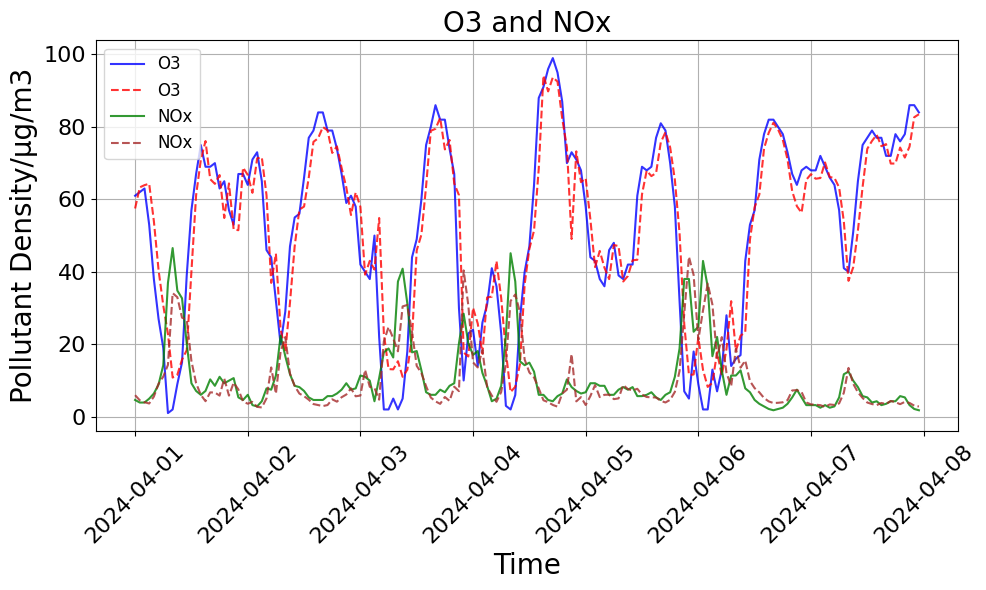

In [35]:
plot_predictions_2(y_test_1=y_test_df_actual["O3"], predictions_1=predictions_df_actual["O3"], 
                   y_test_2=y_test_df_actual["NOx"], predictions_2=predictions_df_actual["NOx"], 
                   title_1_actual="O3", title_1_predicted="O3", 
                   title_2_actual="NOx", title_2_predicted="NOx", title="O3 and NOx", y_label = "Pollutant Density/\u03bcg/m3")

/var/folders/nl/1bxm2b0s3j7f15g_30xsck8r0000gn/T/ipykernel_43583/4053307316.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start='2024-04-01 00:00:00', end='2024-04-07 23:00:00', freq='H')


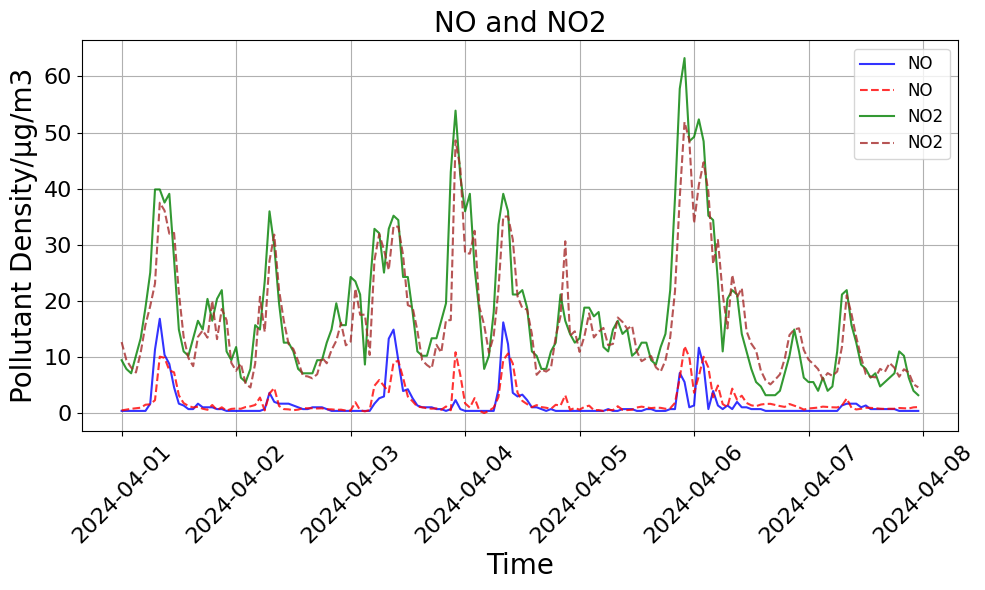

In [36]:
plot_predictions_2(y_test_1=y_test_df_actual["NO"], predictions_1=predictions_df_actual["NO"], 
                   y_test_2=y_test_df_actual["NO2"], predictions_2=predictions_df_actual["NO2"], 
                   title_1_actual="NO", title_1_predicted="NO", 
                   title_2_actual="NO2", title_2_predicted="NO2", title="NO and NO2", y_label = "Pollutant Density/\u03bcg/m3")

### Calculate Errors

In [ ]:
mae_no, mse_no, rmse_no = calculate_errors(y_test_df_actual["NO"], predictions_df_actual["NO"])
mae_no2, mse_no2, rmse_no2 = calculate_errors(y_test_df_actual["NO2"], predictions_df_actual["NO2"])
mae_nox, mse_nox, rmse_nox = calculate_errors(y_test_df_actual["NOx"], predictions_df_actual["NOx"])
mae_o3, mse_o3, rmse_o3 = calculate_errors(y_test_df_actual["O3"], predictions_df_actual["O3"])
#mae_pm10, mse_pm10, rmse_pm10 = calculate_errors(y_test_df["PM10"], predictions_df["PM10"])

mae = [mae_no, mae_no2, mae_nox, mae_o3]
mse = [mse_no, mse_no2, mse_nox, mse_o3]
rmse = [rmse_no, rmse_no2, rmse_nox, rmse_o3]


### Plot Errors

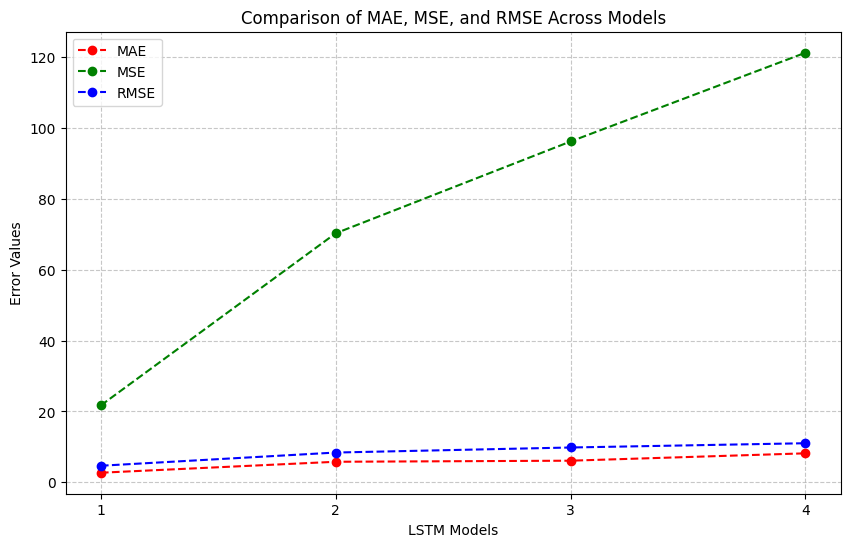

[2.686675166700365, 5.7790282891974565, 6.082251223550559, 8.162427308880503]

In [ ]:
plot_errors(mae, mse, rmse)

mae

In [ ]:
mae

[2.686675166700365, 5.7790282891974565, 6.082251223550559, 8.162427308880503]

In [ ]:
mse

[21.70152415424952, 70.28515939556885, 96.20044154010327, 121.25707555783195]

In [ ]:
rmse

[4.658489471303924, 8.383624478444204, 9.808182376980113, 11.01167905261645]